# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "C:\Users\gyuugyuu\anaconda3\envs\py310\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "C:\Users\gyuugyuu\anaconda3\envs\py310\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "C:\Users\gyuugyuu\anaconda3\envs\py310\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "C:\Users\gyuugyuu\anaconda3\envs\py310\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in _parse_requirement_details
          marker = _parse_require

In [2]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
flatbuffers                  24.3.25
gast                         0.4.0
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.62.1
h5py                         3.11.0
idna                         3.7
importlib_metadata           7.1.0
ipykernel                    6.29.3
ipython                      8.22.2
jedi                         0.19.1
jupyter_client               8.6.1
jupyter_core                 5.7.2
keras 

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 854 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

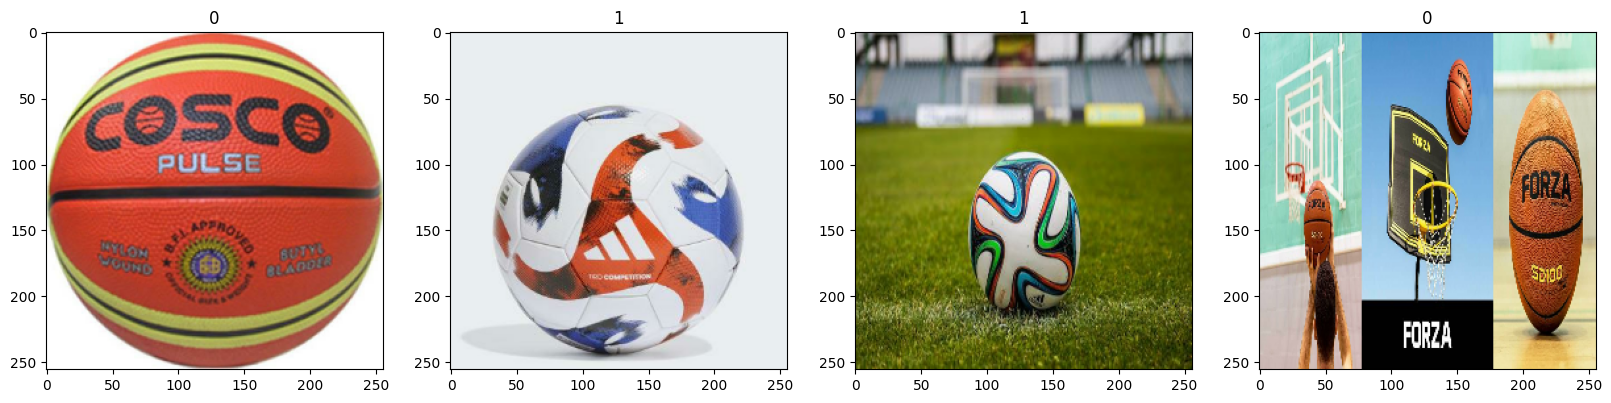

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          ...,
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ]],
 
         [[0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          ...,
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ]],
 
         [[0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          ...,
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ],
          [0.91764706, 0.93333334, 0.9372549 ]],
 
         ...,
 
         [[0.91764706, 0.93333334, 0.9372549 ],
          [0.91764

# 5. Split Data

In [18]:
len(data)

27

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1 
test_size = int(len(data)*.1)+1

In [20]:
print(test_size, val_size, train_size)

3 6 18


In [21]:
train_size + val_size + test_size

27

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25


18/18 [==============================] - 14s 225ms/step - loss: 1.0236 - accuracy: 0.5712 - val_loss: 0.6362 - val_accuracy: 0.5833
Epoch 2/25
18/18 [==============================] - 8s 403ms/step - loss: 0.5919 - accuracy: 0.6979 - val_loss: 0.5860 - val_accuracy: 0.6771
Epoch 3/25
18/18 [==============================] - 7s 384ms/step - loss: 0.5295 - accuracy: 0.7604 - val_loss: 0.5040 - val_accuracy: 0.7604
Epoch 4/25
18/18 [==============================] - 7s 384ms/step - loss: 0.4724 - accuracy: 0.8003 - val_loss: 0.5123 - val_accuracy: 0.7500
Epoch 5/25
18/18 [==============================] - 7s 383ms/step - loss: 0.4195 - accuracy: 0.8264 - val_loss: 0.5139 - val_accuracy: 0.7656
Epoch 6/25
18/18 [==============================] - 7s 394ms/step - loss: 0.5045 - accuracy: 0.7760 - val_loss: 0.4437 - val_accuracy: 0.8594
Epoch 7/25
18/18 [==============================] - 7s 383ms/step - loss: 0.3837 - accuracy: 0.8385 - val_loss: 0.4037 - val_accuracy: 0.8385
Epoch 8/25
18/18

# 8. Plot Performance

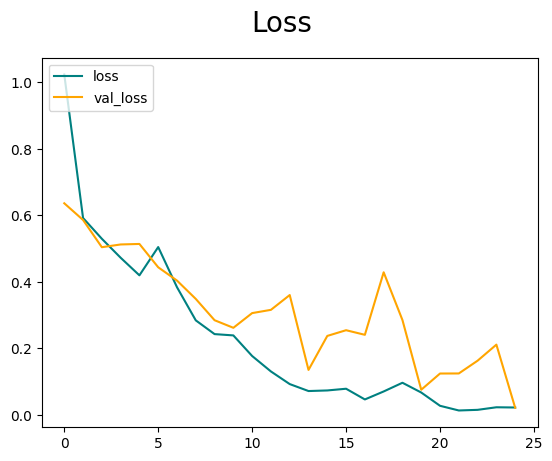

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

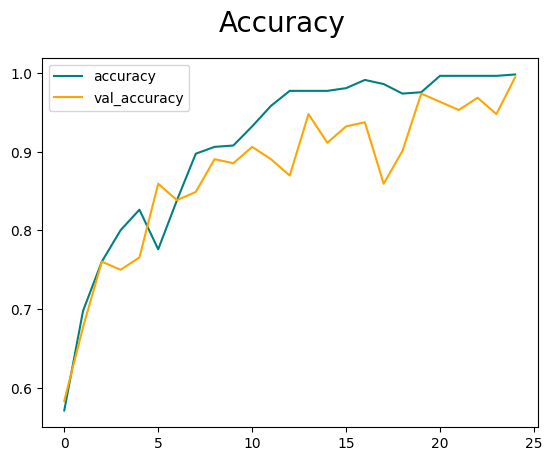

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9302326, shape=(), dtype=float32) tf.Tensor(0.96511626, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2, random

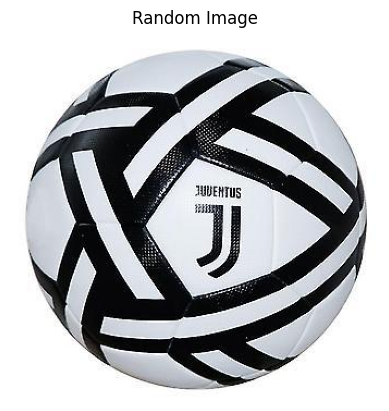

"\nimg = cv2.imread('two.jpeg')\nplt.imshow(img)\nplt.show()\n"

In [39]:
image_dir = "test/football"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick a random image file
random_image_file = random.choice(image_files)

# Load the random image
img = cv2.imread(os.path.join(image_dir, random_image_file))

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Random Image")
plt.axis('off')
plt.show()

"""
img = cv2.imread('two.jpeg')
plt.imshow(img)
plt.show()
"""

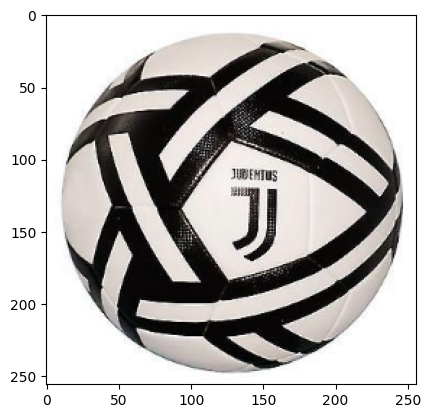

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 506ms/step


In [42]:
yhat

array([[0.9999944]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is football')
else:
    print(f'Predicted class is basketball')

Predicted class is football


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [75]:
model.save(os.path.join('models', 'imageclassifier.h5'))

In [76]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [77]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 110ms/step


array([[0.9999944]], dtype=float32)

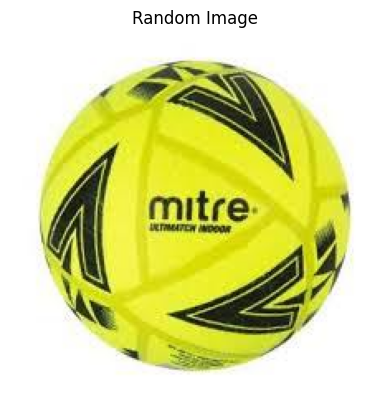

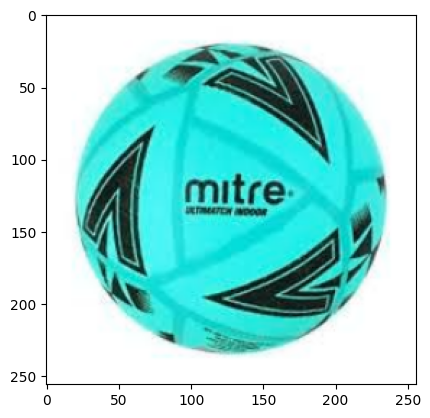

In [78]:
image_dir = "test/football"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick a random image file
random_image_file = random.choice(image_files)

# Load the random image
img = cv2.imread(os.path.join(image_dir, random_image_file))

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Random Image")
plt.axis('off')
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [79]:
yhat = model.predict(np.expand_dims(resize/255, 0)) 

if yhat > 0.5: 
    print(f'Predicted class is football')
else:
    print(f'Predicted class is basketball')
print(yhat)

1/1 [==============================] - 0s 30ms/step
Predicted class is football
[[0.99986804]]
